In [1]:
from gurobi import *
import numpy as np
import pandas as pd
from scipy.spatial import distance
from itertools import chain, combinations
import matplotlib.pyplot as plt
import os, sys

# PDSTSP


In [2]:
class Data:
    def __init__(self):
        self.customerNum = 0 
        self.nodeNum     = 0 
        self.droneNum    = 2
        self.cities      = []
        self.cor_X       = [] 
        self.cor_Y       = [] 
        self.serviceTime = [] 
        self.disMatrix   = [[]]
        self.dt          = None
        self.i_pot = None
        self.cus_can_served_by_drone = None
        self.drone_distances = None
        self.truck_distances = None
        self.model = None
      
        

    def readData(self, path):
        self.dt = pd.read_csv(path, header = None).to_numpy()[:-1]
        self.customerNum = len(self.dt)
        self.i_pot = self.dt[0, 1:3]
        self.nodeNum = self.customerNum + 2 
        self.cor_X = [self.dt[i, 1:3][0] for i in range(len(self.dt))]
        self.cor_Y = [self.dt[i, 1:3][1] for i in range(len(self.dt))]
        self.cities = [self.dt[i, 0] for i in range(len(self.dt))]
        
        self.cus_can_served_by_drone = [i for i in range(len(self.dt)) if self.dt[i, 3] == 0]
        
        self.drone_distances = [round(distance.euclidean((self.dt[i, 1:3]), self.i_pot),2)
                                if self.dt[i, 3] == 0 else float('inf')
                                for i in range(len(self.dt))]
        self.truck_distances = [[round(distance.cityblock(self.dt[i, 1:3], self.dt[j, 1:3]),1)
                                 for i in range(len(self.dt))] for j in range(len(self.dt))]
    

        #Decision variables

        # x_ij if (i->j) in vehicle tour
        # # y_im = 1 if cus i assigned to drone m ()

        self.x = None  
        self.y = None 
    def addConstrs(self):
        
        
        #SET
        V = [i for i in range(self.customerNum)]
        C = [i for i in range (1, self.customerNum)]
        U = [k for k in range(self.droneNum)]

        C_U = data.cus_can_served_by_drone


        C_truck = {(i,j): self.truck_distances[i][j] for i in V for j in V}
        C_drone = self.drone_distances

        self.x = [[[] for i in V] for j in V]  
        self.y = [[[] for i in V] for k in U] 
        
        
        #1
        #completion time
        alpha = self.model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, "traveltime")
        self.model.update()
        expr = LinExpr(0)
        expr.addTerms(1.0, alpha)

        self.model.setObjective(expr, GRB.MINIMIZE)
        expr.clear()

        #2
        expr = LinExpr(0)
        for i in V:
            for j in V:
                if i != j:
                    self.x[i][j] = self.model.addVar(0, 1, vtype = GRB.BINARY,name = "x%d,%d" %(i,j))

                    self.model.update()
                    expr.addTerms(self.truck_distances[i][j], self.x[i][j])
                else:
                    self.x[i][i] = self.model.addVar(0.0, 1.0, 0.0, GRB.BINARY, "x%d,%d" %(i,j))

#         print(expr)

        self.model.addConstr(alpha >= expr, "truckTime")
        expr.clear()
        self.model.update()



        #3
        for k in U:
            expr = LinExpr(0)
            for i in C:

                if i in C_U:
                    self.y[k][i] = self.model.addVar(0,1, vtype= GRB.BINARY, name =  "y%d,%d" %(k,i))
#                     print(i)

                    expr.addTerms(self.drone_distances[i], self.y[k][i])
                else:
                    self.y[k][i] = self.model.addVar(0, 0, vtype = GRB.BINARY, name = "y%d,%d" %(k,i))
            self.model.update()
#             print(expr)
            self.model.addConstr(alpha >= expr, "dronetime")
            expr.clear()
        expr.clear()    


        #4
        for j in C:

            expr1 = LinExpr(0)
            expr2 = LinExpr(0)

            for i in V:

                expr1.addTerms(1.0, self.x[i][j])
#                 print(expr1)

            if j in C_U:
                for k in U:
                    expr2.addTerms(1.0, self.y[k][j])

#             print(expr2)
#             print("------------------")

            self.model.addConstr(expr1 + expr2 == 1, "served customer once")
            expr1.clear()
            expr2.clear()
        expr1.clear()
        expr2.clear()


        #5
        for i in C:

            expr1 = LinExpr(0)
            expr2 = LinExpr(0)

            for j in V:

                expr1.addTerms(1.0, self.x[i][j])
#             print(expr1)
            if i in C_U:
                for k in U:
                    expr2.addTerms(1.0, self.y[k][i])

#             print(expr2)
#             print("------------------")
            self.model.addConstr(expr1 + expr2 == 1, "served customer once")
            expr1.clear()
            expr2.clear()
        expr1.clear()
        expr2.clear()


        #6
        for i in C:
            expr1 = LinExpr(0)
            expr2 = LinExpr(0)

            for j in V:

                expr1.addTerms(1.0, self.x[j][i])

            for h in V:

                expr2.addTerms(1.0, self.x[i][h])
            self.model.addConstr(expr1 == expr2, "flow conservation")
            expr1.clear()
            expr2.clear()
        expr1.clear()
        expr2.clear()



        #get all subtours
        def powerset(iterable):
            "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
            s = list(iterable)
            return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

        S = list(powerset(range(1, len(data.cities))))
        # The first element of the list is the empty set and the last element is the full set, hence we remove them.
        S = S[1:(len(S))]
        S = [list(s) for s in S]

#         print(len(S))
#         import sys
#         print(sys.getsizeof(S)/1024/1024," GB")
#         print(type(S))



        # for s in S:

        #         s.insert(0,0)
        S.insert(0,[0])
        S = S[0:len(S) -1 ]
        # print(S)
        # S = [[0,1,2,3,4]]


        #7
        for s in S:
            expr1 = LinExpr(0)
            expr2 = LinExpr(0)

            for i in s:
                for j in V:
                    if j not in s:
                        expr1.addTerms(1.0, self.x[i][j])

                for k in U:
                    if i in C_U:
                        expr2.addTerms(1.0, self.y[k][i])
            self.model.update()
#     print(expr1)
#     print(expr2)
            self.model.addConstr(expr1 + expr2 >= 1)
            expr1.clear()
            expr2.clear()


        

In [3]:
path = "/home/quanghuy205/PDSTSP_model/min-cost VRPD instances/min-cost VRPD-MurrayChu/PDSTSP_10_customer_problems"
dirs = os.listdir(path)
problems_list = [file for file in dirs]

print(problems_list)


['20140813T111714.csv', '20140813T111744.csv', '20140813T111836.csv', '20140813T111729.csv', '20140813T111731.csv', '20140813T111619.csv', '20140813T111628.csv', '20140813T111716.csv', '20140813T111611.csv', '20140813T111950.csv', '20140813T111746.csv', '20140813T112001.csv', '20140813T111750.csv', '20140813T111931.csv', '20140813T111644.csv', '20140813T111740.csv', '20140813T111655.csv', '20140813T111640.csv', '20140813T112005.csv', '20140813T111912.csv', '20140813T111725.csv', '20140813T111927.csv', '20140813T111910.csv', '20140813T111626.csv', '20140813T111659.csv', '20140813T111959.csv', '20140813T111718.csv', '20140813T111941.csv', '20140813T111813.csv', '20140813T111630.csv', '20140813T111805.csv', '20140813T111830.csv', '20140813T111916.csv', '20140813T112003.csv', '20140813T111642.csv', '20140813T111807.csv', '20140813T111623.csv', '20140813T111735.csv', '20140813T111948.csv', '20140813T111705.csv', '20140813T111849.csv', '20140813T111841.csv', '20140813T111824.csv', '20140813T

In [4]:
results = []
for prob in problems_list:  
    data = Data()
    data.model = Model("PDSTSP")
    data.readData("/home/quanghuy205/PDSTSP_model/min-cost VRPD instances/min-cost VRPD-MurrayChu/PDSTSP_10_customer_problems/" + prob)
    data.addConstrs()

    data.model.optimize()
    results.append(data.model.ObjVal)
results
    

Academic license - for non-commercial use only - expires 2021-07-04
Using license file /home/quanghuy205/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 15567 nonzeros
Model fingerprint: 0x896ee3d1
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 102.4000001
Presolve removed 11 rows and 14 columns
Presolve time: 0.01s
Presolved: 530 rows, 105 columns, 15411 nonzeros
Variable types: 0 continuous, 105 integer (104 binary)

Root relaxation: objective 2.220000e+01, 64 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

H    0     0                      30.9200000   22.78342  26.3%     -    0s
H    0     0                      30.8000000   22.78342  26.0%     -    0s
     0     0   24.62655    0   12   30.80000   24.62655  20.0%     -    0s
     0     0   25.00000    0   14   30.80000   25.00000  18.8%     -    0s
H    0     0                      28.6000000   25.60000  10.5%     -    0s
     0     0   25.60000    0   15   28.60000   25.60000  10.5%     -    0s
     0     0   25.66057    0   15   28.60000   25.66057  10.3%     -    0s
     0     0   26.20000    0   12   28.60000   26.20000  8.39%     -    0s
     0     0   26.37816    0   12   28.60000   26.37816  7.77%     -    0s
     0     0   26.65528    0   10   28.60000   26.65528  6.80%     -    0s
     0     0   26.84521    0   13   28.60000   26.84521  6.14%     -    0s
     0     0   27.61992    0   14   28.60000   27.61992  3.43%     -    0s
     0     0   27.61992    0   13   28.60000   27.61992  3.43%     -    0s
     0     0   27.61992  


Optimal solution found (tolerance 1.00e-04)
Best objective 3.580000000000e+01, best bound 3.580000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 16083 nonzeros
Model fingerprint: 0x886d132c
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 105.8000004
Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 531 rows, 107 columns, 15942 nonzeros
Found heuristic solution: objective 105.8000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.846415e+01, 69 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.29483    0   19   62.20000   10.29483  83.4%     -    0s
H    0     0                      45.6000000   10.29483  77.4%     -    0s
H    0     0                      31.4000000   10.29483  67.2%     -    0s
     0     0   12.29167    0   14   31.40000   12.29167  60.9%     -    0s
H    0     0                      20.0000000   12.29167  38.5%     -    0s
H    0     0                      17.0000000   12.29167  27.7%     -    0s
     0     0   12.33023    0   13   17.00000   12.33023  27.5%     -    0s
     0     0   12.73939    0   14   17.00000   12.73939  25.1%     -    0s
H    0     0                      15.7800000   12.73939  19.3%     -    0s
     0     0   12.88919    0   20   15.78000   12.88919  18.3%     -    0s
     0     0   13.21519    0   18   15.78000   13.21519  16.3%     -    0s
     0     0   13.29000    0   24   15.78000   13.29000  15.8%     -    0s
     0     0   13.2920


Root relaxation: objective 1.451545e+01, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   14.51545    0   18  112.80000   14.51545  87.1%     -    0s
H    0     0                      71.0000000   14.51545  79.6%     -    0s
H    0     0                      44.4000000   14.51545  67.3%     -    0s
H    0     0                      41.6000000   14.51545  65.1%     -    0s
H    0     0                      39.4000000   14.51545  63.2%     -    0s
     0     0   18.30111    0   19   39.40000   18.30111  53.6%     -    0s
H    0     0                      38.7000000   18.30111  52.7%     -    0s
H    0     0                      36.6000000   18.30111  50.0%     -    0s
     0     0   18.33457    0   21   36.60000   18.33457  49.9%     -    0s
     0     0   18.98914    0   27   36.60000   18.98914  48.1%     -    0s
H    0     0                

     0     0   15.80546    0   26   24.60000   15.80546  35.8%     -    0s
     0     0   16.70544    0   31   24.60000   16.70544  32.1%     -    0s
     0     0   16.80000    0   27   24.60000   16.80000  31.7%     -    0s
     0     2   16.80000    0   24   24.60000   16.80000  31.7%     -    0s
*  157    31              23      24.4500000   16.80000  31.3%   5.6    0s
*  174    31              21      23.8000000   16.80000  29.4%   5.6    0s
H  293    33                      23.2500000   16.80000  27.7%   5.4    0s
H  302    33                      23.2000000   16.80000  27.6%   5.4    0s
H  339    31                      22.8000000   16.90466  25.9%   5.3    0s

Cutting planes:
  Gomory: 4
  Cover: 1
  MIR: 15
  Inf proof: 1
  Zero half: 9

Explored 499 nodes (2543 simplex iterations) in 0.38 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 22.8 23.2 23.25 ... 40.6

Optimal solution found (tolerance 1.00e-04)
Best objective 2.280000000000e+01, best boun

Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.168835e+01, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.68835    0   15   59.40000   11.68835  80.3%     -    0s
H    0     0                      25.8000000   11.68835  54.7%     -    0s
H    0     0                      19.8000000   11.68835  41.0%     -    0s
H    0     0                      14.4000000   11.68835  18.8%     -    0s
     0     0   12.05542    0   20   14.40000   12.05542  16.3%     -    0s
H    0     0                      14.2000000   12.05542  15.1%     -    0s
     0     0   12.09200    0   18   14.20000   12.09200  14.8%     -    0s
     0     0   12.25368    0   22   14.20000   12.25368  13.7%     -    0s
     0     0   12.44416    0   28   14.20000   12.44416  12.4%     -    0s
H    0     0                      13.6800000   1

Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 531 rows, 107 columns, 15943 nonzeros
Found heuristic solution: objective 91.2000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.522991e+01, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.22991    0   19   91.20000   15.22991  83.3%     -    0s
H    0     0                      63.2000000   15.22991  75.9%     -    0s
H    0     0                      26.0100000   15.22991  41.4%     -    0s
H    0     0                      23.2700000   15.22991  34.6%     -    0s
     0     0   18.95020    0   13   23.27000   18.95020  18.6%     -    0s
     0     0   22.28000    0   22   23.27000   22.28000  4.25%     -    0s
H    0     0                      23.2000000   22.28000  3.97%     -    0s
H    0     0                      22.4000

H    0     0                      32.6000000   17.50029  46.3%     -    0s
H    0     0                      31.0000000   17.50029  43.5%     -    0s
H    0     0                      30.4400000   17.50029  42.5%     -    0s
H    0     0                      24.4300000   17.50029  28.4%     -    0s
     0     0   20.20423    0   12   24.43000   20.20423  17.3%     -    0s
     0     0   20.65542    0   20   24.43000   20.65542  15.5%     -    0s
     0     0   20.71896    0   19   24.43000   20.71896  15.2%     -    0s
     0     0   20.71896    0   20   24.43000   20.71896  15.2%     -    0s
     0     0   21.53073    0   19   24.43000   21.53073  11.9%     -    0s
     0     0   21.53073    0   10   24.43000   21.53073  11.9%     -    0s
     0     0   21.53073    0   18   24.43000   21.53073  11.9%     -    0s
     0     0   21.53073    0   22   24.43000   21.53073  11.9%     -    0s
     0     0   21.53073    0   21   24.43000   21.53073  11.9%     -    0s
     0     0   21.53073  

Optimize a model with 541 rows, 119 columns and 16083 nonzeros
Model fingerprint: 0x1cb0648d
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 90.4000003
Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 531 rows, 107 columns, 15943 nonzeros
Found heuristic solution: objective 90.4000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 2.167165e+01, 51 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.67165    0   14   90.40000   21.67165  76.0%     -    0s
H    0     0                      28.4000000   21.67165  23.7%     -    0s
H    0     0                      28.1700000   21.67165  23.1

H    0     0                      12.8000000   10.08311  21.2%     -    0s
H    0     0                      12.5300000   10.08311  19.5%     -    0s
     0     0   10.53547    0   25   12.53000   10.53547  15.9%     -    0s
     0     0   10.77043    0   26   12.53000   10.77043  14.0%     -    0s
     0     0   11.50856    0   15   12.53000   11.50856  8.15%     -    0s
     0     0   11.67378    0   16   12.53000   11.67378  6.83%     -    0s
     0     0   11.70000    0   15   12.53000   11.70000  6.62%     -    0s
     0     0   12.12956    0   25   12.53000   12.12956  3.20%     -    0s
     0     0   12.26453    0   25   12.53000   12.26453  2.12%     -    0s
     0     0   12.35222    0   27   12.53000   12.35222  1.42%     -    0s
     0     0   12.40000    0   28   12.53000   12.40000  1.04%     -    0s
     0     0   12.41889    0   28   12.53000   12.41889  0.89%     -    0s

Cutting planes:
  Gomory: 5
  Cover: 1
  MIR: 7
  StrongCG: 1
  Zero half: 4

Explored 1 nodes (171

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 16083 nonzeros
Model fingerprint: 0x70fedc41
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 113.3999999
Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 531 rows, 107 columns, 15942 nonzeros
Found heuristic solution: objective 113.4000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 3.748571e+01, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   37.48571    0    6  113.40000   37.48571  66.9%     -    0s

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.96437    0   17  161.80000   24.96437  84.6%     -    0s
H    0     0                     123.8000000   24.96437  79.8%     -    0s
H    0     0                      73.4000000   24.96437  66.0%     -    0s
H    0     0                      55.7000000   24.96437  55.2%     -    0s
H    0     0                      45.0000000   24.96437  44.5%     -    0s
     0     0   29.77724    0   17   45.00000   29.77724  33.8%     -    0s
     0     0   29.77860    0   18   45.00000   29.77860  33.8%     -    0s
     0     0   29.84646    0   18   45.00000   29.84646  33.7%     -    0s
H    0     0                      42.6000000   29.84646  29.9%     -    0s
H    0     0                      38.9500000   30.96824  20.5%     -    0s
H    0     0                      38.4700000   30.96824  19.5%     -    0s
     0     0   30.96824    0   22   38.47000   30.96824  19.5%     -    0s
     0     0   31.1011

Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.830396e+01, 64 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   18.30396    0   12   70.20000   18.30396  73.9%     -    0s
H    0     0                      27.6000000   18.30396  33.7%     -    0s
H    0     0                      22.4000000   18.30396  18.3%     -    0s
H    0     0                      22.2000000   18.30396  17.5%     -    0s
H    0     0                      21.7600000   18.30396  15.9%     -    0s
H    0     0                      20.8000000   19.70606  5.26%     -    0s
     0     0   20.66984    0    9   20.80000   20.66984  0.63%     -    0s

Cutting planes:
  Gomory: 3

Explored 1 nodes (78 simplex iterations) in 0.05 seconds
Thread count was 12 (of 12 available processors)

Solution count 6: 20.8 21.76 22.2 ... 70.2

Optimal solution 

Optimize a model with 541 rows, 119 columns and 16599 nonzeros
Model fingerprint: 0x125449cb
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 72.4000003
Presolve removed 9 rows and 10 columns
Presolve time: 0.01s
Presolved: 532 rows, 109 columns, 16476 nonzeros
Found heuristic solution: objective 72.4000000
Variable types: 0 continuous, 109 integer (108 binary)

Root relaxation: objective 1.152611e+01, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.52611    0   15   72.40000   11.52611  84.1%     -    0s
H    0     0                      42.4000000   11.52611  72.8%     -    0s
H    0     0                      28.8000000   11.52611  60.0%

     0     0   11.52205    0   30   14.35000   11.52205  19.7%     -    0s
     0     0   11.59217    0   24   14.35000   11.59217  19.2%     -    0s
     0     0   11.60025    0   22   14.35000   11.60025  19.2%     -    0s
     0     0   11.82528    0   21   14.35000   11.82528  17.6%     -    0s
     0     0   11.83282    0   25   14.35000   11.83282  17.5%     -    0s
     0     0   11.86137    0   26   14.35000   11.86137  17.3%     -    0s
     0     0   12.32583    0   35   14.35000   12.32583  14.1%     -    0s
     0     0   12.32583    0   35   14.35000   12.32583  14.1%     -    0s
     0     2   12.32583    0   35   14.35000   12.32583  14.1%     -    0s

Cutting planes:
  Gomory: 4
  Cover: 3
  Clique: 2
  MIR: 9
  Inf proof: 1
  Zero half: 8

Explored 210 nodes (1182 simplex iterations) in 0.27 seconds
Thread count was 12 (of 12 available processors)

Solution count 7: 14.35 16 17.16 ... 64.4

Optimal solution found (tolerance 1.00e-04)
Best objective 1.435000000000e+01, 

     0     0   13.53000    0   14   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   18   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   18   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   15   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   17   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   21   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   17   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   22   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   21   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   21   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   25   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   27   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000    0   22   13.80000   13.53000  1.96%     -    0s
     0     0   13.53000  

Found heuristic solution: objective 123.2000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.740453e+01, 56 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.40453    0   19  123.20000   17.40453  85.9%     -    0s
H    0     0                      71.6000000   17.40453  75.7%     -    0s
H    0     0                      51.2000000   17.40453  66.0%     -    0s
H    0     0                      39.6000000   17.40453  56.0%     -    0s
H    0     0                      32.1200000   18.23821  43.2%     -    0s
     0     0   20.62811    0   19   32.12000   20.62811  35.8%     -    0s
     0     0   23.52666    0   20   32.12000   23.52666  26.8%     -    0s
H    0     0                      29.8000000   23.52666  21.1%     -    0s
H    0     0                      27.8000000   23.52666  15.4%     -    0s


     0     0   40.30000    0   12   66.20000   40.30000  39.1%     -    0s
H    0     0                      65.4000000   40.30000  38.4%     -    0s
H    0     0                      55.8000000   40.30000  27.8%     -    0s
     0     0   43.26667    0   15   55.80000   43.26667  22.5%     -    0s
H    0     0                      54.4000000   43.26667  20.5%     -    0s
     0     0   44.40000    0   12   54.40000   44.40000  18.4%     -    0s
     0     0   44.40000    0   13   54.40000   44.40000  18.4%     -    0s
     0     0   44.60000    0   13   54.40000   44.60000  18.0%     -    0s
     0     0   44.60000    0   17   54.40000   44.60000  18.0%     -    0s
     0     0   44.60000    0   17   54.40000   44.60000  18.0%     -    0s
     0     0   44.60000    0   11   54.40000   44.60000  18.0%     -    0s
     0     0   44.60000    0   12   54.40000   44.60000  18.0%     -    0s
     0     0   46.30000    0    7   54.40000   46.30000  14.9%     -    0s
     0     0   46.30000  

H    0     0                      20.2500000   12.90608  36.3%     -    0s
H    0     0                      18.6000000   12.90608  30.6%     -    0s
H    0     0                      14.0000000   12.90608  7.81%     -    0s
     0     0   13.12004    0   21   14.00000   13.12004  6.29%     -    0s
     0     0   13.12004    0   12   14.00000   13.12004  6.29%     -    0s
     0     0   13.12004    0   20   14.00000   13.12004  6.29%     -    0s
     0     0   13.12004    0   21   14.00000   13.12004  6.29%     -    0s
     0     0   14.00000    0   20   14.00000   14.00000  0.00%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 1
  MIR: 5
  Zero half: 4

Explored 1 nodes (231 simplex iterations) in 0.11 seconds
Thread count was 12 (of 12 available processors)

Solution count 7: 14 18.6 20.25 ... 51.4

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+01, best bound 1.400000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread

     0     0    8.38000    0   19   13.60000    8.38000  38.4%     -    0s
     0     0    8.38000    0   18   13.60000    8.38000  38.4%     -    0s
     0     0   10.14427    0   22   13.60000   10.14427  25.4%     -    0s
     0     0   10.62969    0   23   13.60000   10.62969  21.8%     -    0s
     0     0   10.70000    0   23   13.60000   10.70000  21.3%     -    0s
     0     0   12.01000    0   23   13.60000   12.01000  11.7%     -    0s
H    0     0                      13.4000000   12.01000  10.4%     -    0s
     0     0   12.01000    0   20   13.40000   12.01000  10.4%     -    0s
     0     0   12.01000    0   26   13.40000   12.01000  10.4%     -    0s
     0     0   12.01000    0   23   13.40000   12.01000  10.4%     -    0s
     0     2   12.01000    0   23   13.40000   12.01000  10.4%     -    0s

Cutting planes:
  Gomory: 5
  Cover: 1
  MIR: 4
  Zero half: 6

Explored 324 nodes (1548 simplex iterations) in 0.31 seconds
Thread count was 12 (of 12 available processors)


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 16599 nonzeros
Model fingerprint: 0xea6528ce
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 149.9999998
Presolve removed 9 rows and 10 columns
Presolve time: 0.01s
Presolved: 532 rows, 109 columns, 16476 nonzeros
Found heuristic solution: objective 150.0000000
Variable types: 0 continuous, 109 integer (108 binary)

Root relaxation: objective 2.467817e+01, 70 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   24.67817    0   14  150.00000   24.67817  83.5%     -    0s


Presolve time: 0.02s
Presolved: 531 rows, 107 columns, 15943 nonzeros
Found heuristic solution: objective 84.2000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.541773e+01, 58 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.41773    0   15   84.20000   15.41773  81.7%     -    0s
H    0     0                      45.2000000   15.41773  65.9%     -    0s
H    0     0                      37.8000000   15.41773  59.2%     -    0s
H    0     0                      28.4000000   15.41773  45.7%     -    0s
     0     0   18.87572    0   19   28.40000   18.87572  33.5%     -    0s
H    0     0                      23.2000000   18.87572  18.6%     -    0s
H    0     0                      23.0700000   18.87572  18.2%     -    0s
     0     0   21.11553    0   13   23.07000   21.11553  8.47%     -    0s
H    0

     0     0   46.80000    0   16   48.40000   46.80000  3.31%     -    0s
     0     0   46.80000    0    6   48.40000   46.80000  3.31%     -    0s
     0     0   46.80000    0    8   48.40000   46.80000  3.31%     -    0s

Cutting planes:
  Gomory: 5
  Clique: 2
  MIR: 1
  Zero half: 12
  RLT: 4

Explored 1 nodes (160 simplex iterations) in 0.14 seconds
Thread count was 12 (of 12 available processors)

Solution count 5: 48.4 52 57.4 ... 86.4

Optimal solution found (tolerance 1.00e-04)
Best objective 4.840000000000e+01, best bound 4.840000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 15567 nonzeros
Model fingerprint: 0xc3e2a5a4
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        

Found heuristic solution: objective 63.8000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.075578e+01, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.75578    0   12   63.80000   10.75578  83.1%     -    0s
H    0     0                      16.5200000   10.75578  34.9%     -    0s
H    0     0                      14.7700000   10.75578  27.2%     -    0s
     0     0   12.22740    0   18   14.77000   12.22740  17.2%     -    0s
     0     0   12.22740    0   19   14.77000   12.22740  17.2%     -    0s
H    0     0                      13.7400000   12.22740  11.0%     -    0s
H    0     0                      13.4000000   12.22740  8.75%     -    0s
     0     0     cutoff    0        13.40000   13.40000  0.00%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 1
  Zero half: 4
  RLT: 2

Explored 1 

Thread count was 12 (of 12 available processors)

Solution count 6: 31.8 33.6 36 ... 80.6

Optimal solution found (tolerance 1.00e-04)
Best objective 3.180000000000e+01, best bound 3.180000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 16083 nonzeros
Model fingerprint: 0x98f3e18e
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 63.5999999
Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 531 rows, 107 columns, 15941 nonzeros
Found heuristic solution: objective 63.6000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.384356e+01, 57 iterations, 0.00 seconds

    Nodes    |

     0     0   31.26667    0   23   38.60000   31.26667  19.0%     -    0s
     0     0   32.39070    0   23   38.60000   32.39070  16.1%     -    0s
     0     0   32.41493    0   19   38.60000   32.41493  16.0%     -    0s
     0     0   35.42000    0   18   38.60000   35.42000  8.24%     -    0s
     0     0   35.42000    0   23   38.60000   35.42000  8.24%     -    0s
     0     0   36.75173    0   15   38.60000   36.75173  4.79%     -    0s
H    0     0                      38.4400000   37.00858  3.72%     -    0s
     0     0   37.00858    0   26   38.44000   37.00858  3.72%     -    0s
     0     0   37.39893    0   27   38.44000   37.39893  2.71%     -    0s
     0     0   37.39893    0   20   38.44000   37.39893  2.71%     -    0s
     0     2   37.39893    0   20   38.44000   37.39893  2.71%     -    0s

Cutting planes:
  Cover: 2
  MIR: 7
  Zero half: 12

Explored 89 nodes (723 simplex iterations) in 0.23 seconds
Thread count was 12 (of 12 available processors)

Solution cou

H    0     0                      10.3900000    8.68725  16.4%     -    0s
     0     0    9.21267    0   26   10.39000    9.21267  11.3%     -    0s
     0     0    9.40000    0   26   10.39000    9.40000  9.53%     -    0s
     0     0    9.74122    0   28   10.39000    9.74122  6.24%     -    0s
     0     0    9.80000    0   26   10.39000    9.80000  5.68%     -    0s
     0     0   10.10000    0   31   10.39000   10.10000  2.79%     -    0s
     0     0   10.39000    0   29   10.39000   10.39000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 1
  MIR: 11
  Zero half: 5

Explored 1 nodes (190 simplex iterations) in 0.17 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 10.39 10.93 11.07 ... 41

Optimal solution found (tolerance 1.00e-04)
Best objective 1.039000000000e+01, best bound 1.039000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.774036e+01, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.74036    0   15   95.40000   17.74036  81.4%     -    0s
H    0     0                      50.2000000   17.74036  64.7%     -    0s
H    0     0                      40.6000000   17.74036  56.3%     -    0s
     0     0   19.32729    0   18   40.60000   19.32729  52.4%     -    0s
H    0     0                      36.4700000   19.32729  47.0%     -    0s
     0     0   19.88091    0   20   36.47000   19.88091  45.5%     -    0s
H    0     0                      36.3600000   19.88091  45.3%     -    0s
     0     0   19.89190    0   23   36.36000   19.89190  45.3%     -    0s
H    0     0                      33.5000000   19.89190  40.6%     -    0s
     0     0   21.00594    0   23   33.50000   2

Presolved: 531 rows, 107 columns, 15943 nonzeros
Found heuristic solution: objective 49.6000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.237469e+01, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.37469    0   16   49.60000   12.37469  75.1%     -    0s
H    0     0                      35.2000000   12.37469  64.8%     -    0s
H    0     0                      27.6000000   12.37469  55.2%     -    0s
H    0     0                      26.8000000   12.37469  53.8%     -    0s
H    0     0                      20.2000000   14.25557  29.4%     -    0s
     0     0   15.58715    0   21   20.20000   15.58715  22.8%     -    0s
     0     0   18.22912    0   24   20.20000   18.22912  9.76%     -    0s
     0     0   18.70000    0   23   20.20000   18.70000  7.43%     -    0s

Cutting planes:
  Gomory: 

     0     0   15.16490    0   19   16.20000   15.16490  6.39%     -    0s
H    0     0                      15.8000000   15.16490  4.02%     -    0s

Cutting planes:
  Gomory: 3
  Implied bound: 1
  MIR: 7
  StrongCG: 1
  Zero half: 2

Explored 1 nodes (204 simplex iterations) in 0.12 seconds
Thread count was 12 (of 12 available processors)

Solution count 7: 15.8 16.2 16.39 ... 64.8

Optimal solution found (tolerance 1.00e-04)
Best objective 1.580000000000e+01, best bound 1.580000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 16083 nonzeros
Model fingerprint: 0x16ecc3b9
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 78.4000001

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 50.4000001
Presolve removed 11 rows and 14 columns
Presolve time: 0.01s
Presolved: 530 rows, 105 columns, 15408 nonzeros
Variable types: 0 continuous, 105 integer (104 binary)

Root relaxation: objective 1.084377e+01, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   10.84377    0   13   50.40000   10.84377  78.5%     -    0s
H    0     0                      27.0000000   10.84377  59.8%     -    0s
H    0     0                      22.6000000   10.84377  52.0%     -    0s
H    0     0                      19.4000000   10.84377  44.1%     -    0s
     0     0   11.27191    0   17   19.40000   11.27191  41.9%     -    0s
     0     0   11.37281    0   19   19.40000   11.37281  41.4%     -    0s
     0     0  

Model fingerprint: 0x62ed085d
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [7e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 58.3999999
Presolve removed 10 rows and 12 columns
Presolve time: 0.01s
Presolved: 531 rows, 107 columns, 15943 nonzeros
Found heuristic solution: objective 58.4000000
Variable types: 0 continuous, 107 integer (106 binary)

Root relaxation: objective 1.525117e+01, 61 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   15.25117    0   16   58.40000   15.25117  73.9%     -    0s
H    0     0                      57.2000000   15.25117  73.3%     -    0s
H    0     0                      43.0000000   15.25117  64.5%     -    0s
H    0     0                      42.2000000   15

H    0     0                      35.8000000   34.30203  4.18%     -    0s
     0     0     cutoff    0        35.80000   35.80000  0.00%     -    0s

Explored 1 nodes (68 simplex iterations) in 0.06 seconds
Thread count was 12 (of 12 available processors)

Solution count 6: 35.8 36.39 36.4 ... 84.4

Optimal solution found (tolerance 1.00e-04)
Best objective 3.580000000000e+01, best bound 3.580000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 119 columns and 15567 nonzeros
Model fingerprint: 0x47289dde
Variable types: 1 continuous, 118 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 145.0000000
Presolve removed 11 rows and 14 columns
Presolve time: 0.01s
Presolved: 530 rows, 105

H    0     0                      32.2000000   12.65011  60.7%     -    0s
H    0     0                      24.6000000   12.65011  48.6%     -    0s
H    0     0                      19.9600000   12.65011  36.6%     -    0s
     0     0   15.10000    0   11   19.96000   15.10000  24.3%     -    0s
H    0     0                      19.7300000   15.10000  23.5%     -    0s
H    0     0                      19.2500000   15.10000  21.6%     -    0s
H    0     0                      19.0000000   15.10000  20.5%     -    0s
     0     0   16.09123    0   16   19.00000   16.09123  15.3%     -    0s
H    0     0                      18.8000000   16.09123  14.4%     -    0s
     0     0   16.09123    0   10   18.80000   16.09123  14.4%     -    0s
     0     0   16.09123    0   16   18.80000   16.09123  14.4%     -    0s
     0     0   16.09123    0   16   18.80000   16.09123  14.4%     -    0s
     0     0   16.40000    0   10   18.80000   16.40000  12.8%     -    0s
     0     0   16.40000  

Variable types: 0 continuous, 105 integer (104 binary)

Root relaxation: objective 2.656556e+01, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   26.56556    0   12  127.40000   26.56556  79.1%     -    0s
H    0     0                      37.6000000   26.56556  29.3%     -    0s
     0     0   30.30000    0   15   37.60000   30.30000  19.4%     -    0s
     0     0   33.50000    0   14   37.60000   33.50000  10.9%     -    0s
     0     0   36.00000    0   13   37.60000   36.00000  4.26%     -    0s
     0     0   37.20000    0   13   37.60000   37.20000  1.06%     -    0s

Cutting planes:
  Gomory: 4
  MIR: 2
  Zero half: 5
  RLT: 1
  Relax-and-lift: 2

Explored 1 nodes (102 simplex iterations) in 0.09 seconds
Thread count was 12 (of 12 available processors)

Solution count 3: 37.6 127.4 127.4 

Optimal solution found (tolerance 1.00e-04)
B

[23.8,
 26.0,
 22.32,
 28.6,
 20.6,
 50.4,
 35.8,
 22.6,
 27.799999999999997,
 15.780000000000001,
 22.21,
 15.1,
 35.79,
 17.9,
 38.81,
 22.8,
 45.0,
 39.8,
 13.68,
 22.03,
 29.6,
 27.799999999999997,
 22.28,
 28.400000000000002,
 48.6,
 19.6,
 24.43,
 11.53,
 25.6,
 47.599999999999994,
 25.080000000000002,
 20.6,
 17.39,
 12.530000000000001,
 39.4,
 27.84,
 40.459999999999994,
 24.4,
 18.4,
 36.8,
 20.8,
 17.59999999999997,
 20.8,
 34.2,
 17.21,
 22.240000000000002,
 18.31,
 29.2,
 20.2,
 14.35,
 45.06999999999999,
 29.8,
 13.8,
 18.13,
 11.98,
 32.35,
 26.66,
 14.8,
 16.2,
 54.39999999999999,
 43.4,
 23.0,
 13.999999999999998,
 22.2,
 24.2,
 36.59,
 13.399999999999999,
 37.12,
 30.6,
 20.2,
 36.4,
 22.599999999999998,
 24.2,
 22.52,
 37.6,
 19.37,
 48.4,
 30.0,
 25.2,
 28.599999999999998,
 13.4,
 29.75,
 20.2,
 31.8,
 16.2,
 22.599999999999998,
 31.580000000000002,
 38.44,
 26.799999999999997,
 31.4,
 10.39,
 37.0,
 23.6,
 30.2,
 31.88,
 36.19,
 28.619999999999997,
 20.2,
 22.2,
 24

In [25]:
for r in results:
    print (prob)
    

20140813T111714.csv
20140813T111744.csv
20140813T111836.csv
20140813T111729.csv
20140813T111731.csv
20140813T111619.csv
20140813T111628.csv
20140813T111716.csv
20140813T111611.csv
20140813T111950.csv
20140813T111746.csv
20140813T112001.csv
20140813T111750.csv
20140813T111931.csv
20140813T111644.csv
20140813T111740.csv
20140813T111655.csv
20140813T111640.csv
20140813T112005.csv
20140813T111912.csv
20140813T111725.csv
20140813T111927.csv
20140813T111910.csv
20140813T111626.csv
20140813T111659.csv
20140813T111959.csv
20140813T111718.csv
20140813T111941.csv
20140813T111813.csv
20140813T111630.csv
20140813T111805.csv
20140813T111830.csv
20140813T111916.csv
20140813T112003.csv
20140813T111642.csv
20140813T111807.csv
20140813T111623.csv
20140813T111735.csv
20140813T111948.csv
20140813T111705.csv
20140813T111849.csv
20140813T111841.csv
20140813T111824.csv
20140813T111811.csv
20140813T111956.csv
20140813T111722.csv
20140813T111843.csv
20140813T111708.csv
20140813T111922.csv
20140813T111943.csv


In [6]:
data.model.printAttr('X')


    Variable            X 
-------------------------
  traveltime         37.6 
        x0,5            1 
        x2,8            1 
        x5,2            1 
        x8,0            1 
        y0,1            1 
        y0,6            1 
        y0,7            1 
        y1,3            1 
        y1,4            1 
        y1,9            1 


In [7]:
data.model.getVars()

[<gurobi.Var traveltime (value 37.6)>,
 <gurobi.Var x0,0 (value 0.0)>,
 <gurobi.Var x0,1 (value 0.0)>,
 <gurobi.Var x0,2 (value 0.0)>,
 <gurobi.Var x0,3 (value 0.0)>,
 <gurobi.Var x0,4 (value 0.0)>,
 <gurobi.Var x0,5 (value 1.0)>,
 <gurobi.Var x0,6 (value 0.0)>,
 <gurobi.Var x0,7 (value 0.0)>,
 <gurobi.Var x0,8 (value 0.0)>,
 <gurobi.Var x0,9 (value 0.0)>,
 <gurobi.Var x1,0 (value 0.0)>,
 <gurobi.Var x1,1 (value 0.0)>,
 <gurobi.Var x1,2 (value 0.0)>,
 <gurobi.Var x1,3 (value 0.0)>,
 <gurobi.Var x1,4 (value 0.0)>,
 <gurobi.Var x1,5 (value 0.0)>,
 <gurobi.Var x1,6 (value 0.0)>,
 <gurobi.Var x1,7 (value 0.0)>,
 <gurobi.Var x1,8 (value 0.0)>,
 <gurobi.Var x1,9 (value 0.0)>,
 <gurobi.Var x2,0 (value 0.0)>,
 <gurobi.Var x2,1 (value 0.0)>,
 <gurobi.Var x2,2 (value 0.0)>,
 <gurobi.Var x2,3 (value 0.0)>,
 <gurobi.Var x2,4 (value 0.0)>,
 <gurobi.Var x2,5 (value 0.0)>,
 <gurobi.Var x2,6 (value 0.0)>,
 <gurobi.Var x2,7 (value 0.0)>,
 <gurobi.Var x2,8 (value 1.0)>,
 <gurobi.Var x2,9 (value 0.0)>,
 

NameError: name 'truck_tours' is not defined

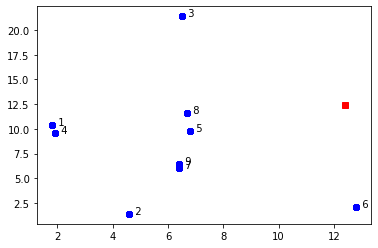

In [8]:
U = [k for k in range(data.droneNum)]

C_U = data.cus_can_served_by_drone

plt.plot(data.i_pot[0], data.i_pot[1], c='r', marker='s')
# plt.scatter(xc[1:], yc[1:], c='b')
for i in range(1,data.customerNum):
    plt.scatter(data.cor_X, data.cor_Y, c='b')
    plt.annotate(str("  ") + str(int(data.cities[i])), (data.cor_X[i], data.cor_Y[i]))
    
for i, j in truck_tours:
    plt.plot([data.cor_X[i], data.cor_X[j]], [data.cor_Y[i], data.cor_Y[j]], c='g', zorder=0)
    
    
default_width = 1

for k in U:
    default_width+= 2
    for i in C_U:
        if data.y[k][i].x > 0.99:
            plt.plot([data.i_pot[0],data.cor_X[i]], [data.i_pot[1], data.cor_Y[i]], color='black', linestyle='dashed', linewidth = default_width)